In [1]:
import matplotlib.pyplot as plt
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
spark = SparkSession.builder.appName("project").getOrCreate()

## Import Data

In [3]:
prices = spark.read.csv("hdfs://namenode:9000/price.csv", header=True, inferSchema=True)
spec = spark.read.csv("hdfs://namenode:9000/specification.csv", header=True, inferSchema=True)

## Preprocessing

Pre-process the data by eliminating unused columns and removing any tuples with null values. An additional column is added for the prices data, containing only the year of the trade time. This improves the efficiency of the following queries, since they all use only the year of the tradingTime. The preprocessing eliminated the need for duplicate computations for the queries, reducing computational time.

The specs data have the constructionTime column filtered to remove any bad data, since corrupted data exist.

In [10]:
prices_dropped_columns = ["followers"]
spec_dropped_columns = ["fiveYearsProperty", "buildingType", "buildingStructure"]

min_prices = prices.drop(*prices_dropped_columns).dropna(how="all")
min_prices = min_prices.withColumn("tradeYear", year(to_date(prices["tradeTime"], "d/MM/yyyy")))

min_spec = spec.drop(*spec_dropped_columns).dropna(how="all")
# Keep only rows where constructionTime matches the "YYYY" pattern (four digits)
min_spec = min_spec.filter(min_spec["constructionTime"].rlike("^[0-9]{4}$"))

Print out samples from both data to verify pre-processing worked.

In [11]:
min_prices.show(10)
min_spec.show(10)

+-----------+----------+---------+----------+----+----------+-----+----------------+---------+
|         id|       Lng|      Lat| tradeTime| DOM|totalPrice|price|communityAverage|tradeYear|
+-----------+----------+---------+----------+----+----------+-----+----------------+---------+
|1.01085E+11|116.475489| 40.01952| 9/08/2016|1464|     415.0|31680|           56021|     2016|
|1.01086E+11|116.453917|39.881534|28/07/2016| 903|     575.0|43436|           71539|     2016|
|1.01086E+11|116.561978|39.877145|11/12/2016|1271|    1030.0|52021|           48160|     2016|
|1.01086E+11| 116.43801|40.076114|30/09/2016| 965|     297.5|22202|           51238|     2016|
|1.01087E+11|116.428392|39.886229|28/08/2016| 927|     392.0|48396|           62588|     2016|
|1.01087E+11| 116.46628|39.991363|22/07/2016| 861|     275.6|52000|           67738|     2016|
|1.01087E+11|116.482586|39.891991|14/07/2016| 851|     275.0|37672|           50112|     2016|
|1.01087E+11|116.453917|39.881534| 7/09/2016| 904|

## Create views and tables

Temporate views created for using spark sql to extract insights from the data.

In [12]:
min_prices.createOrReplaceTempView("Prices")
min_spec.createOrReplaceTempView("Specs")

## CRUD Operation

The total value of all the properties were combined and written to the csv.

In [7]:
# Get total value of all properties
total_property_value = spark.sql("""
SELECT SUM(P.price * S.square) AS totalPropertyValue
FROM Prices AS P
JOIN Specs AS S ON P.id = S.id
""")

total_property_value.createOrReplaceTempView("Total_Property_Value")

total_property_value.show()

# Write result to hadoop
total_property_value.write.csv("hdfs://namenode:9000/total_property_value.csv", header=True, mode="overwrite")

+--------------------+
|  totalPropertyValue|
+--------------------+
|1.316658388058597...|
+--------------------+



## Change in average house price over the years

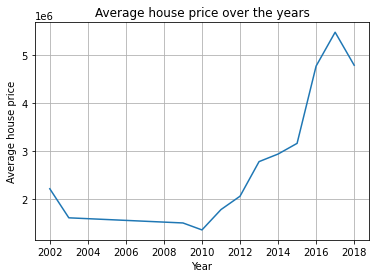

In [16]:
avg_house_price = spark.sql("""
SELECT
    P.tradeYear as year,
    AVG(P.price * S.square) AS avgPrice
FROM Prices AS P
JOIN Specs AS S ON P.id = S.id
GROUP BY P.tradeYear
ORDER BY P.tradeYear
""").toPandas()

plt.plot(avg_house_price["year"], avg_house_price["avgPrice"])
plt.xlabel("Year")
plt.ylabel("Average house price")
plt.title("Average house price over the years")
plt.grid()
plt.show()

Graph showed an exponential growth in house price before hitting a ceiling in 2017, where the first sharp drop in price is seen since the beginning of the real estate boom. The drop in 2017 is a sign of downturn in the property market, which is an early sign for the later property crash. This showed the unsustainability of sharp and strong property market growth, and serves as a warning for home buyers and property investors in other markets.

## Change in average in price per square for each district over the years

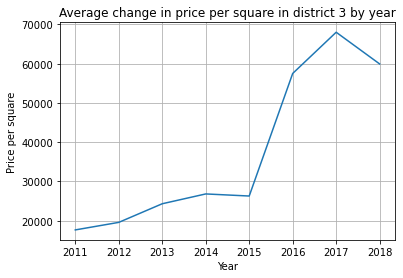

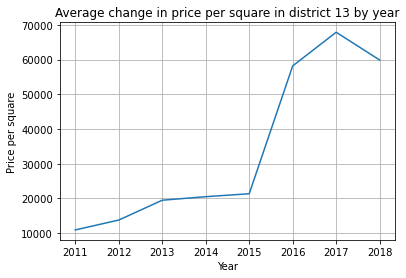

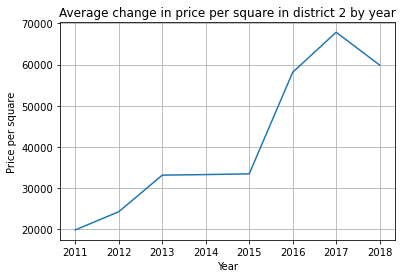

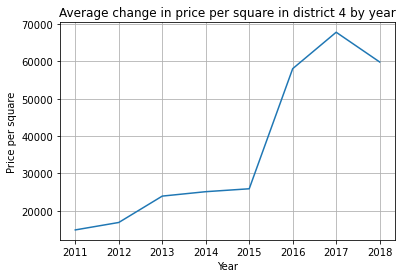

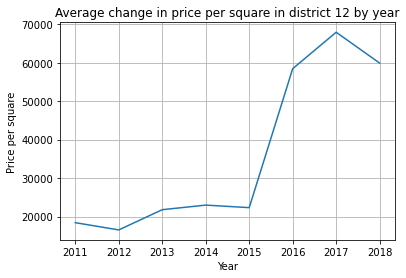

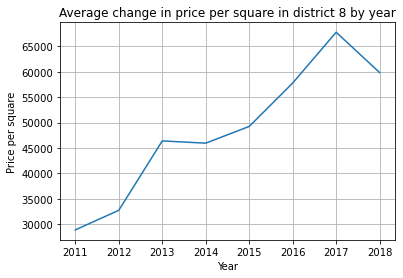

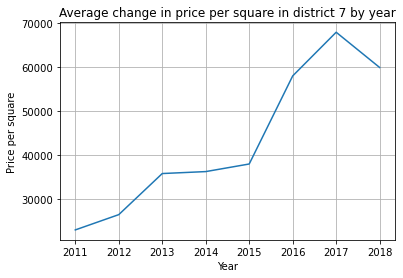

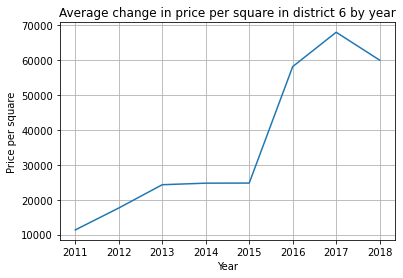

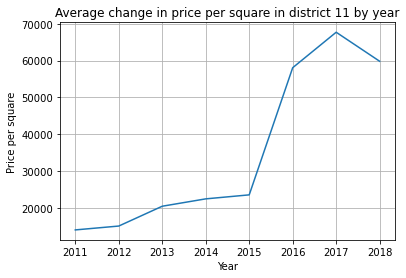

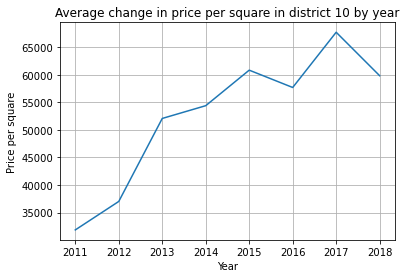

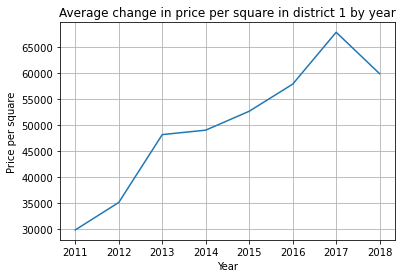

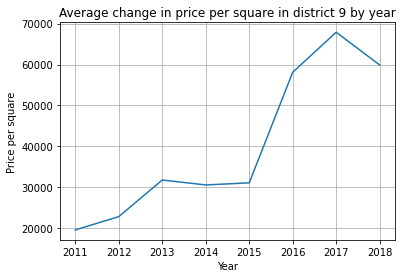

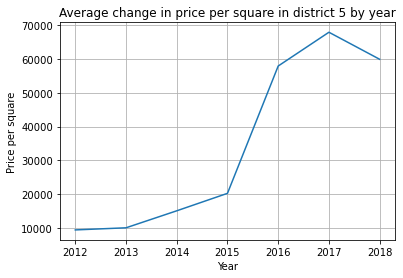

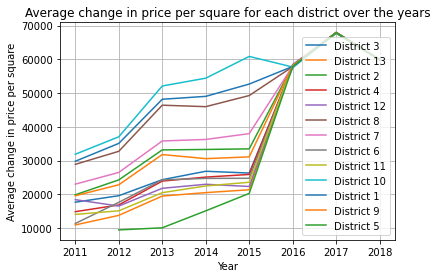

In [14]:
district_price = spark.sql("""
SELECT
    P.tradeYear AS year,
    AVG(P.price) AS avgPrice,
    S.district AS district
FROM Prices AS P
JOIN Specs AS S ON P.id = S.id
WHERE P.tradeYear >= 2011
GROUP BY P.tradeYear, S.district
ORDER BY P.tradeYear
""").toPandas()

# Plot change of price per square for each district separately
for district in district_price["district"].unique():  # Use unique districts
    data = district_price[district_price["district"] == district]
    plt.plot(data["year"], data["avgPrice"])  # Plot filtered data
    plt.xlabel("Year")
    plt.ylabel("Price per square")
    plt.title(f"Average change in price per square in district {district} by year")
    plt.grid()
    plt.show()

# Show change of every district on one graph
for district in district_price["district"].unique():
    data = district_price[district_price["district"] == district]
    plt.plot(data["year"], data["avgPrice"], label=f"District {district}")

plt.xlabel("Year")
plt.ylabel("Average change in price per square")
plt.title("Average change in price per square for each district over the years")
plt.legend()  # Add legend for all lines
plt.grid()
plt.show()

The price for each district over the years are plotted, this can help consumers looking to buy properties in Beijing find the district with the highest price per square and future growth. Here, district 10 showed a drop in price prior to the 2017 drop, this is a sign of weakness in price, and buyers should be careful when considering purchasing in the area.

## Change in house specifications over the years

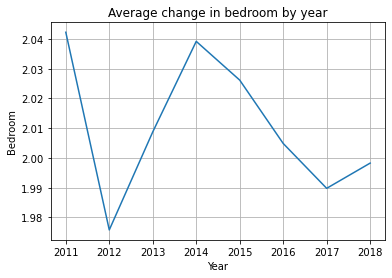

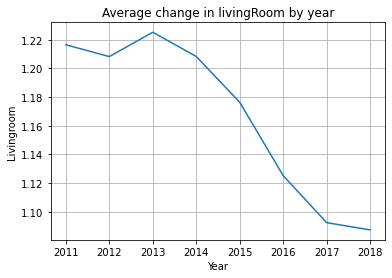

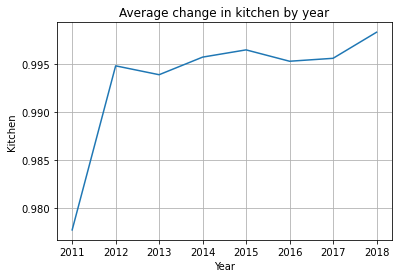

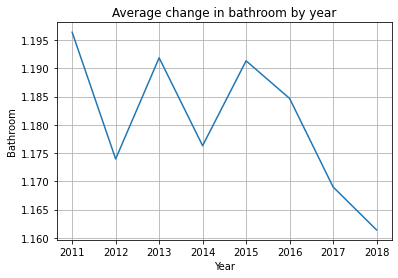

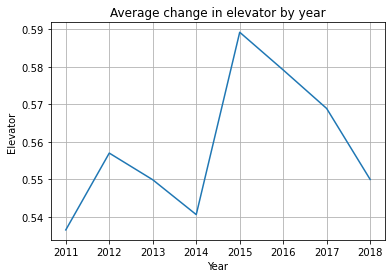

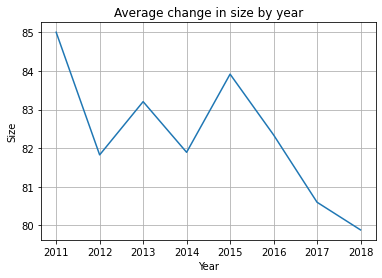

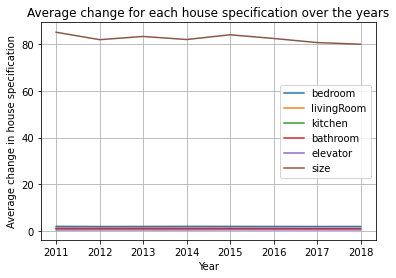

In [13]:
# Corrected SQL query with AVG aggregation
house_specifications = spark.sql("""
SELECT
    P.tradeYear AS year,
    AVG(S.livingRoom) AS bedroom,
    AVG(S.drawingRoom) AS livingRoom,
    AVG(S.kitchen) AS kitchen,
    AVG(S.bathRoom) AS bathroom,
    AVG(S.elevator) AS elevator,
    AVG(S.square) AS size
FROM Prices AS P
JOIN Specs AS S ON P.id = S.id
WHERE P.tradeYear >= 2011
GROUP BY P.tradeYear
ORDER BY P.tradeYear
""").toPandas()

# Plot change of each house specification on a separate graph
specification_fields = ["bedroom", "livingRoom", "kitchen", "bathroom", "elevator", "size"]
for field in specification_fields:
    plt.plot(house_specifications["year"], house_specifications[field])
    plt.xlabel("Year")
    plt.ylabel(field.capitalize())  # Capitalizing ylabel
    plt.title(f"Average change in {field} by year")
    plt.grid()
    plt.show()

# Show change of every house specification on one graph
for field in specification_fields:
    plt.plot(house_specifications["year"], house_specifications[field], label=field)

plt.xlabel("Year")
plt.ylabel("Average change in house specification")
plt.title("Average change for each house specification over the years")
plt.legend()  # Add legend for all lines
plt.grid()
plt.show()

The plots showing the change in house characteristics revealed an overall slow but decreasing trend in the overall size of the properties. The data aligns with the strong demand for limited space during the real estate boom.

However, the rest of the characteristics, including number of bedrooms, bathrooms, livingrooms all stayed fairly constant. The constant characteristics indicate Beijing's family size to have remained constant for a long time, a very possible after effect of the strict one child policy.

This shows a trend for smaller properties in the future, and buyers should take that into consideration when purchasing larger properties, since demand is concentrated in the smaller properties.

## Function to compare change in price per year between 2 districts

In [22]:
def compare(district1, district2):
    districtPrice = spark.sql(f"""
    SELECT 
        P.tradeYear AS year,
        AVG(P.price * S.square) AS avgPrice,
        S.district AS district
    FROM Prices AS P
    JOIN Specs AS S ON P.id = S.id
    WHERE S.district IN ({district1}, {district2})
    GROUP BY P.tradeYear, S.district
    ORDER BY P.tradeYear
    """).toPandas()

    district1Price = districtPrice[districtPrice["district"] == district1]
    district2Price = districtPrice[districtPrice["district"] == district2]
    
    plt.plot(district1Price["year"], district1Price["avgPrice"], label=f"District {district1}")
    plt.plot(district2Price["year"], district2Price["avgPrice"], label=f"District {district2}")
    
    plt.xlabel("Year")
    plt.ylabel("Average house price")
    plt.title("Average house price over the years")
    plt.legend()
    plt.grid()
    plt.show()

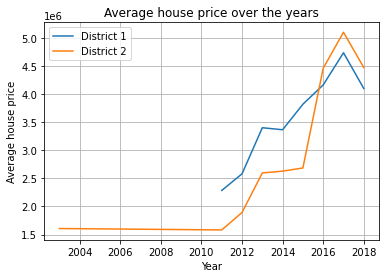

In [23]:
compare(1, 2)

The function allows consumers to easily compare the price between any two districts and decide which one has the best price growth and economic outlook. This is useful as purchasing a property is an important decision to make, and a direct comparison between can be helpful when deciding between two districts. 